In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time
from bnlp.corpus import stopwords
from bnlp.corpus.util import remove_stopwords
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
 
#plt.style.use('ggplot')

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [16]:
DATA_PATH = '/content/drive/MyDrive/data/Bangla_Corpus.csv'
df = pd.read_csv(DATA_PATH)

df.head()

,Unnamed: 0,text,label,target
0,0,অবিশ^াস্য কিন্তু সত্য। প্রাচীনকালে হিন্দু মালা...,Hateful,1
1,1,"আজ বিশ^ হাড়কিপটা দিবস, উইশ করুন আপনার সেই কিপ্...",Neutral,0
2,2,চীনকে চিনে নিতে ৭২ ঘন্টা সময় চায় ভারত।,Hateful,1
3,3,"আমারে নিবা মাঝি লগে? ব্রীজ হইছে, ব্রীজ দিয়া যা।",Neutral,0
4,4,বাম আর নাস্তিক আজ আওয়ামীলীগের পিঠে সওয়ার হয়েছে।,Hateful,1


In [17]:
df = df.drop(df.columns[[0, 2]],axis = 1) # removing unnecessery columns

df.head()

,text,target
0,অবিশ^াস্য কিন্তু সত্য। প্রাচীনকালে হিন্দু মালা...,1
1,"আজ বিশ^ হাড়কিপটা দিবস, উইশ করুন আপনার সেই কিপ্...",0
2,চীনকে চিনে নিতে ৭২ ঘন্টা সময় চায় ভারত।,1
3,"আমারে নিবা মাঝি লগে? ব্রীজ হইছে, ব্রীজ দিয়া যা।",0
4,বাম আর নাস্তিক আজ আওয়ামীলীগের পিঠে সওয়ার হয়েছে।,1


In [18]:
df.shape

(4500, 2)

In [19]:
df.dropna(axis=0, subset=['text'], inplace=True) # Remove documents with missing target values
df.dropna(axis=0, subset=['target'], inplace=True)


df.drop_duplicates(inplace = True) # Dropping Duplicate Documents

check_nan = df['target'].isnull().values.any() # Check Nan values
check_nan2 = df['text'].isnull().values.any() # Check Nan values
print(check_nan2)

False


In [20]:
# After dropping new corpus
# print(df)
df.shape

(4411, 2)

In [21]:
# map classes to labels
df['target'] = df['target'].map({1: 'Offensive', 0: 'Non-offensive'})

df.rename(columns = {'class': 'target', 'tweet': 'text'}, inplace = True)

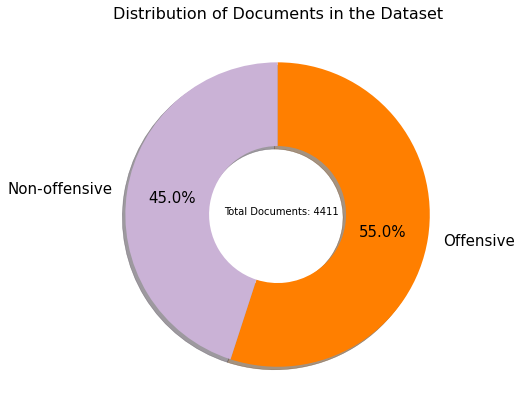

In [22]:
plt.figure(figsize = (7,7))
sorted_counts = df['target'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.55},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Documents: {}'.format(df.shape[0]))
plt.title('Distribution of Documents in the Dataset', fontsize = 16);

In [ ]:
df['target'] = df.target.map({'Offensive': 1, 'Non-offensive': 0})

Corpus Seperation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=261)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 4411
Number of rows in the training set: 3528
Number of rows in the test set: 883


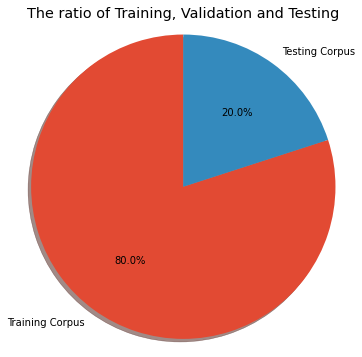

In [ ]:
train_test_ratio = {'Training Corpus': X_train.shape[0], 'Testing Corpus': X_test.shape[0]}

labels = list(train_test_ratio.keys())
sizes = list(train_test_ratio.values())

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('The ratio of Training, Validation and Testing')
# plt.legend()
plt.show()

Bangla Stop Words Extraction

In [ ]:
# Instantiate the TF-IDF method
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords)

# Fit the training data and then return the matrix
training_data = tfidf_vectorizer.fit_transform(X_train)
df = pd.DataFrame(training_data.toarray(), columns=tfidf_vectorizer.get_feature_names())
# df.head()

print (tfidf_vectorizer.vocabulary_)
dictionary = sorted(tfidf_vectorizer.vocabulary_)

print(dictionary)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['অথব', 'অন', 'অবধ', 'অবশ', 'অর', 'আগ', 'আছ', 'আদ', 'আপন', 'আব', 'আম', 'আমর', 'ইত', 'ইহ', 'উই', 'উক', 'উচ', 'উত', 'উন', 'এক', 'একট', 'একব', 'এখ', 'এট', 'এতট', 'এদ', 'এমনক', 'ওক', 'ওখ', 'ওদ', 'ওয', 'ওয়', 'কট', 'কব', 'কমন', 'কয', 'কর', 'করছ', 'করত', 'করব', 'করল', 'কয়', 'খত', 'চল', 'জনক', 'তথ', 'তব', 'তর', 'থম', 'ধর', 'নঐ', 'নও', 'নজন', 'নত', 'নয', 'পক', 'পষ', 'ফল', 'বক', 'বদল', 'বয', 'বর', 'বল', 'বলত', 'বস', 'বহ', 'মত', 'মধ', 'মন', 'যওজ', 'যতট', 'যথ', 'যদ', 'যন', 'যবহ', 'যভ', 'যম', 'রও', 'রণ', 'রত', 'রথম', 'রপর', 'রভ', 'রয', 'রযন', 'লক', 'ষয', 'সঙ', 'সম', 'সমস', 'হইত', 'হইব', 'হইয', 'হওয', 'হচ', 'হব', 'হয'] not in stop_words.
  warnings.warn(


{'কর': 489, 'মল': 1175, 'আন': 125, 'তর': 796, 'আদ': 121, 'লত': 1332, 'নশন': 920, 'সন': 1444, 'আম': 143, 'আছ': 108, 'নত': 896, 'আব': 138, 'নস': 922, 'ইয়': 246, 'সম': 1461, 'কথ': 467, 'বল': 1072, 'আগ': 99, 'ধব': 868, 'বলত': 1076, 'করত': 492, 'হব': 1517, 'ঝত': 697, 'অন': 26, 'কব': 475, 'লছ': 1328, 'উস': 292, 'ওন': 412, 'ইব': 218, 'টয়': 736, 'লক': 1320, 'ফয়': 1010, 'আহম': 172, 'আল': 156, 'দন': 831, 'ডপ': 750, 'আস': 162, 'ঈদ': 247, 'মর': 1168, 'রচ': 1245, 'মন': 1152, 'বড়': 1093, 'কষ': 508, 'ওস': 424, 'ইন': 200, 'ঝল': 702, 'রপ': 1274, 'টওভ': 709, 'ওয়': 429, 'সময়': 1468, 'গব': 574, 'গর': 579, 'ঘব': 599, 'লই': 1316, 'রত': 1256, 'রছ': 1247, 'যদ': 1213, 'লন': 1335, 'ডন': 749, 'তব': 789, 'শন': 1369, 'হওয়': 1501, 'কআপ': 433, 'রণ': 1253, 'চল': 627, 'বভ': 1060, 'মসজ': 1179, 'কঠ': 460, 'শশ': 1386, 'আদর': 122, 'রন': 1272, 'যক': 1194, 'নক': 882, 'পড়ল': 991, 'শরৎক': 1383, 'তক': 771, 'কম': 483, 'বর': 1062, 'এইত': 313, 'গম': 578, 'শর': 1380, 'দব': 837, 'রবল': 1283, 'রস': 1298, 'ছন': 643, 'অব': 39, 'কল': 4

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Transform testing data and return the matrix. Note we are not fitting the testing data into the TfIdfVectorizer()
testing_data = tfidf_vectorizer.transform(X_test)

In [ ]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # probaility of prediction
        y_score = learner.predict_proba(X_test)[:, 1] 
        
        results['y_score_shape'] = y_score.shape

        # ROC curve plotting
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = roc_auc_score(y_test, y_score)

        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (AUC = {:.2f})'.format(roc_auc))
        plt.show()

        results['roc_auc'] = roc_auc # ROC_AUC value

        # store fpr, tpr value
        results['fpr'] = fpr
        results['tpr'] = tpr


        # Store the prediction time
        results['Prediction Time'] = end - start
        
        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

Training MultinomialNB


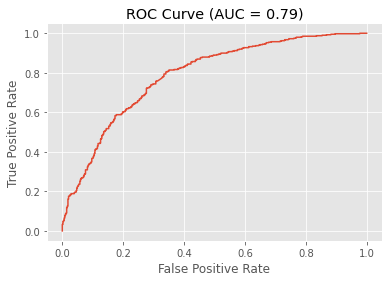

Training MultinomialNB finished in 0.01 sec
----------------------------------------------------
Training DecisionTreeClassifier


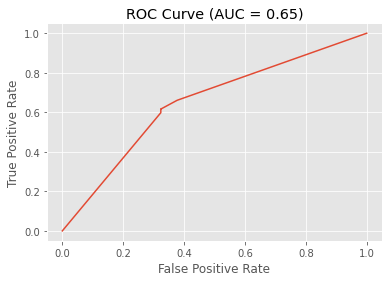

Training DecisionTreeClassifier finished in 0.18 sec
----------------------------------------------------
Training RandomForestClassifier


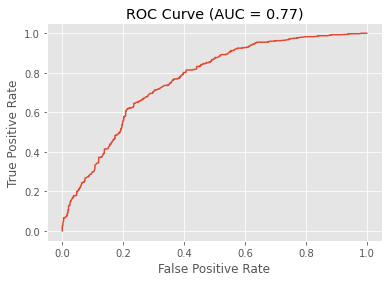

Training RandomForestClassifier finished in 1.47 sec
----------------------------------------------------
Training LogisticRegression


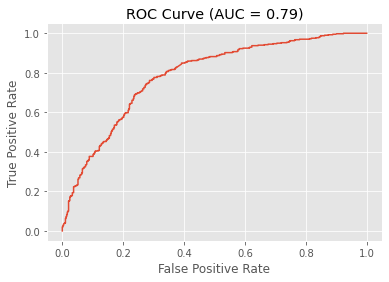

Training LogisticRegression finished in 0.04 sec
----------------------------------------------------
Training KNeighborsClassifier


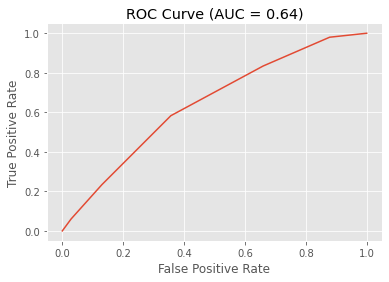

Training KNeighborsClassifier finished in 0.00 sec
----------------------------------------------------


In [ ]:
models = [MultinomialNB(), DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression(), KNeighborsClassifier()]
re = pipeline(models, training_data, y_train, testing_data, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'fpr', 'tpr', 'roc_auc'])

In [ ]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'fpr', 'tpr', 'roc_auc'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

In [ ]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,fpr,tpr,roc_auc
0,LogisticRegression,0.720272,0.701333,0.660804,0.680466,0.802721,0.796407,0.754253,0.774757,"[0.0, 0.0, 0.0, 0.002061855670103093, 0.002061...","[0.0, 0.002512562814070352, 0.0201005025125628...",0.785707
1,MultinomialNB,0.708947,0.684073,0.658291,0.670935,0.817177,0.799618,0.792060,0.795821,"[0.0, 0.0, 0.0, 0.002061855670103093, 0.002061...","[0.0, 0.002512562814070352, 0.0326633165829145...",0.786826
2,RandomForestClassifier,0.705549,0.677835,0.660804,0.669211,0.986678,0.988579,0.981727,0.985141,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0020618556701...","[0.0, 0.002512562814070352, 0.0100502512562814...",0.765083
3,DecisionTreeClassifier,0.650057,0.610422,0.618090,0.614232,0.986678,0.991071,0.979206,0.985103,"[0.0, 0.31958762886597936, 0.3237113402061856,...","[0.0, 0.5904522613065326, 0.5979899497487438, ...",0.648112
4,KNeighborsClassifier,0.616082,0.572840,0.582915,0.577833,0.740363,0.707483,0.720857,0.714107,"[0.0, 0.0288659793814433, 0.12989690721649486,...","[0.0, 0.06030150753768844, 0.23366834170854273...",0.641742


**Perform the PCA**

In [ ]:
pca = PCA(n_components=2)
PC = pca.fit_transform(df)
pca_df = pd.DataFrame(data = PC, columns = ['PC1', 'PC2'])
 
pca_df.head(6)

,PC1,PC2
0,-0.088443,0.142013
1,0.203888,0.225029
2,0.202309,0.188768
3,0.123363,-0.065857
4,-0.055549,0.052319
5,-0.063700,-0.049018


**Visualize the PCA**

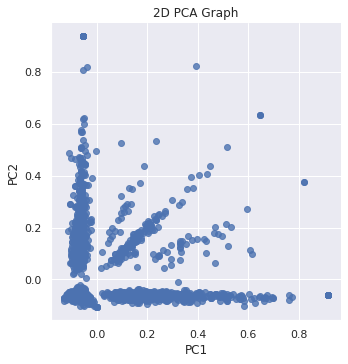

In [ ]:
sns.set()
 
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df,  
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.show()

**Visualize the Explained Variance by each Principal Component**

Text(0.5, 0, 'Principal Components')

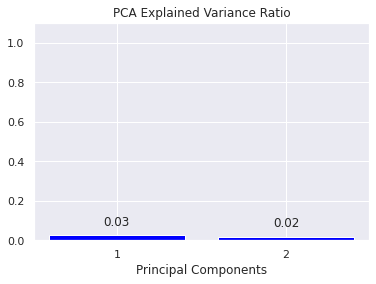

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_, 
    color= "blue"
)
 
for x, y in zip(np.arange(len(df.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
 
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('PCA Explained Variance Ratio')
ax.set_xlabel('Principal Components')

In [ ]:
df_new = pd.DataFrame(pca_df, columns=['PC1'])
 
df_new.head(6)

,PC1
0,-0.088443
1,0.203888
2,0.202309
3,0.123363
4,-0.055549
5,-0.063700
